Calculate Ocean Mixed Layer Budget using decomposition described in Zhang et. al. 2020 and Kang et. al. 2023

In [2]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Process the surface energy budget data

In [1]:
fluxes = [
        "rlds", # surface downwelling longwave flux, all sky
        "rldscs", # surface downwelling longwave flux, clear sky
        "rsds", # surface downwelling shortwave flux, all sky
        "rsdscs", # surface downwelling shortwave flux, clear sky
        "rlus", # surface upwelling longwave flux, all sky
        "rsus", # surface upwelling shortwave flux, all sky (probably don't need)
        "rsuscs", # surface upwelling shortwave flux, clear sky (probably don't need)
        "hfls", # surface upward latent heat flux
        "hfss", # surface upward shortwave heat flux
        "sfcWind", # surface wind speed
        "hur", # surface relative humidity
        "tos", # sea surface temperature
        "tas", # surface air temperature
]
ERA = "CMIP6"

In [ ]:
# def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
#     """Calculate the rolling gradient of a dataset

#     Args:
#         data (xr.DataArray): _description_
#         window (int, optional): _description_. Defaults to 120*30.
#         step (int, optional): _description_. Defaults to 12.

#     Returns:
#         np.array: _description_
#     """
#     if not save: 
#         # load and return
#         return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}.nc")
    
#     grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
#     grads.fill(np.nan)
#     time_idx = xr.DataArray(np.arange(window), dims="time")

#     data = data.chunk({"time": -1})
#     for j, i in enumerate(range(0, len(data.time) - window, step)):
#         grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

#     # Convert to xarray
#     da =  xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})
#     if save:
#         da.to_netcdf(f"data/piControl/rolling_gradient_{name}.nc")
    
#     return da

# calculate_rolling_gradient(SW, save=True, name="SW")


In [47]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a DataArray

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 12*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}.nc")

    grads = np.full((data.model.size, int((len(data.time) - window + step) / step), data.lat.size, data.lon.size), np.nan)
    print(grads.shape)
    # time_idx = xr.DataArray(np.arange(window, dtype="float"), dims="time")
    time_idx = xr.DataArray(np.arange(12*30), dims=("time"))

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window + step, step)):
        print(i, i+window)
        # if j % 10 == 0: print(j)
        grads[:,j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        

    # Convert to xarray
    da =  xr.DataArray(grads, dims=("model", "time", "lat", "lon"), coords={"model": data.model, "lat": data.lat, "lon": data.lon, "time": np.arange(grads.shape[1])})
    
    # if save:
        # da.to_netcdf(f"data/piControl/rolling_gradient_{name}.nc")
    
    return da

# from scipy.stats import linregress
SW_anoms = xr.merge([SW, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
SW_anoms = SW_anoms.temporal.departures("SW", "month")
sw_test = SW_anoms.sel(model="CESM2").isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')

# sw_test = SW.sel(model=["CESM2"]).isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')
# print(sw_test)
# time_idx = xr.DataArray(np.arange(12*30, dtype="float"), dims="time")
# # res = linregress(time_idx, sw_test)
# print(res)
# res = xscore.linslope(time_idx, sw_test, dim='time', skipna=True)
# print(res)
# # plt.plot(time_idx, sw_test)

da = calculate_rolling_gradient(sw_test, save=True, name="SW")
da.values #/ (12*30)

ValueError: operand to apply_ufunc has required core dimensions ['time'], but some of these dimensions are absent on an input variable: ['time']

In [48]:
da = calculate_rolling_gradient(sw_test, save=True, name="SW")
da.values #/ (12*30)

(1, 1, 2, 2)
0 360


ValueError: operand to apply_ufunc has required core dimensions ['time'], but some of these dimensions are absent on an input variable: ['time']

In [46]:
ds = {}
for flux in fluxes: 
    ds[flux] = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")[flux]

ds_raw = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")

# Calculate Surface Energy Budget Terms
LW = (ds["rlds"] - ds["rlus"]).rename("LW") # Net Downward Longwave Radiation
LWC = (LW - ds["rldscs"]).rename("LWC") # Cloud Net Downward Longwave Radiation
SW = (ds["rsds"] - ds["rsus"]).rename("SW") # Net Downward Shortwave Radiation
SWC = (SW - (ds["rsdscs"] - ds["rsuscs"])).rename("SWC") # Cloud Net Downward Shortwave Radiation
DT = (ds["tas"] - 273.15 - ds["tos"]).rename("DT") # Low Atmosphere Stability
SH = ds["hfss"].rename("SH") # Net Upward Sensible Heat Flux
LH = ds["hfls"].rename("LH") # Net Upward Latent Heat Flux
TOS = ds["tos"].rename("TOS") # Sea Surface Temperature
RH = ds["hur"].rename("RH") # Relative Humidity
W = ds["sfcWind"].rename("W") # Wind Speed

LH_Bar = LH.mean("time")
RH_Bar = RH.mean("time")
W_Bar = W.mean("time")
DT_Bar = DT.mean("time")

Lv = 2.5e6 # Latent Heat of Vaporization
Rv = 461.5 # Gas Constant for Water Vapor
alpha = Lv/(Rv*(TOS.mean("time")+273.15)**2)


<xarray.DataArray 'RH' (model: 2, time: 1800, lat: 72, lon: 144)>
array([[[[      nan, ...,       nan],
         ...,
         [87.529526, ..., 87.529526]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       [[[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1999-12-01 00:00:00
    plev     float64 7e+04
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0'
Attributes:
    standard_name:  relative_humidity
    long_name:      Relative Humidity
    comment:        The relative humidity with respect to liquid water for T>...
    units:          %
    cell_methods:   time: mean
    cell_measures:  area: areacella
    regrid_method:  bilinear

In [43]:
# ds_var = xr.merge([SWC, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
# # ds_anoms = ds_var.temporal.departures("SWC", "month")

# global_plot(
#     data=ds_var.mean(["model"], skipna=True).isel(time=0)["SWC"],
#     lat=ds_var.lat,
#     lon=ds_var.lon,
#     pvalues=None, 
#     cmap="YlGnBu_r", 
#     levels=np.arange(-100, 5, 5),
#     left_title="A", 
#     right_title="$SW (W/m^2/dec)$"
# )

In [44]:
# ds_var = xr.merge([SWC, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
# ds_anoms = ds_var.temporal.departures("SWC", "month")

# global_plot(
#     data=ds_anoms.mean(["model"], skipna=True).isel(time=0)["SWC"],
#     lat=ds_var.lat,
#     lon=ds_var.lon,
#     pvalues=None, 
#     cmap="YlGnBu_r", 
#     levels=np.arange(-10, 11, 1),
#     left_title="A", 
#     right_title="$SW (W/m^2/dec)$"
# )

In [109]:
# Merge all terms into one dataset
print("Merging datasets...")
# ds_seb = [LW, LWC, SW, SWC, SH, LH, TOS, RH, W, DT] 
ds_seb = [RH]
# ds_seb = xr.merge([LW, LWC, SW, SWC, SH, LH, TOS, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])

# Calculate Anomalies
print("Calculating Anomalies...")
ds_trends = {}
SAVE = True
for i, var in enumerate(ds_seb): 
    ds_var = xr.merge([var, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
    for var_name in ds_var: 
        print(f"Calculating Anomalies for {var_name}...")
        # ds_anoms = ds_var.temporal.departures(var_name, "month")
        ds_trends[var_name] = calculate_rolling_gradient(ds_var[var_name], save=SAVE, name=var_name)
        break

# Calculate tendency terms

In [5]:
def get_shared_models(vars):
    models = []
    for var in vars:
        models.append(var.model.values)
    shared_models = list(set.intersection(*map(set, models)))
    return shared_models

SH = xr.open_dataarray("data/piControl/rolling_gradient_SH.nc")
LH = xr.open_dataarray("data/piControl/rolling_gradient_SH.nc")
LW = xr.open_dataarray("data/piControl/rolling_gradient_LW.nc")
LWC = xr.open_dataarray("data/piControl/rolling_gradient_LWC.nc")
SW_G = xr.open_dataarray("data/piControl/rolling_gradient_SW.nc")
SWC = xr.open_dataarray("data/piControl/rolling_gradient_SWC.nc")
W = xr.open_dataarray("data/piControl/rolling_gradient_W.nc")
RH = xr.open_dataarray("data/piControl/rolling_gradient_RH.nc")
DT = xr.open_dataarray("data/piControl/rolling_gradient_DT.nc")
TOS = xr.open_dataarray("data/piControl/rolling_gradient_TOS.nc")

shared_models = get_shared_models([SH, LH, LW, LWC, SW, SWC, W, RH, DT, TOS])

SH = SH.sel(model=shared_models) 
LH = LH.sel(model=shared_models) 
LW = LW.sel(model=shared_models) 
LWC = LWC.sel(model=shared_models) 
SW = SW.sel(model=shared_models) 
SWC = SWC.sel(model=shared_models) 
W = W.sel(model=shared_models) 
RH = RH.sel(model=shared_models) 
DT = DT.sel(model=shared_models) 
TOS = TOS.sel(model=shared_models) 

print("Number of shared models: ", len(shared_models))

Number of shared models:  2


In [5]:
# Temperature Tendency Useful for Sanity Check
TOS = xr.open_dataarray("data/piControl/rolling_gradient_TOS.nc")

# Ocean Heat Transport
O = LW + SW - SH - LH # Calculate ocean heat transport as residual
# Ocean Heat Transport Tendency
O_T = O/(alpha*LH_Bar)
# Sensible Heat Flux Tendency
SH_T = SH/(alpha*LH_Bar)
# Longwave Radiative Forcing
LW_T = LW/(alpha*LH_Bar)
# Shortwave Radiative Forcing
SW_T = (SW*12*10)/(alpha*LH_Bar)
# Latent Heat Flux Tendency
LH_TW = W/(alpha*W_Bar) # Wind Driven
LH_TRH = RH/(alpha*(np.exp(alpha*DT_Bar) - RH_Bar)) # Relative Humidity Driven
LH_TDT = RH_Bar*DT/(np.exp(alpha*DT_Bar) - RH_Bar) # Temperature Driven
# Cloud Radiative Forcing
LWC_T = LWC/(alpha*LH_Bar)
SWC_T = SWC/(alpha*LH_Bar)


In [19]:
SW_T

<xarray.DataArray (model: 48, time: 120, lat: 72, lon: 144)>
array([[[[ 6.11000304e+02,  6.86198670e+02,  8.37021315e+02, ...,
           8.37021315e+02,  6.86198670e+02,  6.11000304e+02],
         [ 8.62056349e+03,  5.07248276e+03, -6.31976015e+03, ...,
           1.15166236e+05,  1.95215013e+04,  8.62056349e+03],
         [-4.71589298e+03, -1.23214391e+05, -1.19568381e+05, ...,
          -9.42665547e+04, -8.94400097e+04, -4.71589298e+03],
         ...,
         [-1.66524460e+03, -1.83539567e+03, -1.82780681e+03, ...,
          -2.03610277e+03, -2.05395742e+03, -1.66523903e+03],
         [-8.44150619e+02, -8.34440707e+02, -8.06495312e+02, ...,
          -8.90639701e+02, -8.64475135e+02, -8.44149603e+02],
         [-5.99358434e+02, -5.99629274e+02, -6.00172344e+02, ...,
          -6.00171351e+02, -5.99628778e+02, -5.99358434e+02]],

        [[-1.73419776e+03, -1.63027324e+03, -1.42174992e+03, ...,
          -1.42174992e+03, -1.63027324e+03, -1.73419776e+03],
         [ 6.12264721e+03,  1.99412733e+03, -8.48139144e+03, ...,
           8.21715923e+04,  1.29826607e+04,  6.12264721e+03],
         [-5.81549913e+03, -1.36830459e+05, -1.33033903e+05, ...,
          -8.88185278e+04, -8.45273130e+04, -5.81549913e+03],
...
         [-2.68036389e+01, -1.38300214e+01,  9.08552517e+01, ...,
           2.37002555e+02,  2.24447727e+02,             nan],
         [ 1.28954170e+02,  1.82357651e+02,  3.04457663e+02, ...,
           2.72766861e+02,  3.15514324e+02,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [-1.16306465e+03, -1.41823674e+03, -1.51646869e+03, ...,
          -3.66678707e+02, -6.02781188e+02,             nan],
         [-9.88019498e+02, -1.79488753e+03, -2.70352617e+03, ...,
          -4.35400836e+02, -6.23154054e+02,             nan],
         ...,
         [-1.41687327e+02, -1.31039127e+02, -4.36533179e+01, ...,
           7.53434975e+01,  3.67197761e+01,             nan],
         [ 1.57616396e+02,  2.15897688e+02,  3.28567942e+02, ...,
           2.12418254e+02,  2.34508280e+02,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'E3SM-2-0' 'CanESM5-1'
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

In [25]:
# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    bound_region(ax1, lons=(-95, -70), lats=(-40, -5), color="black")
    # Southern Ocean
    bound_region(ax1, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    bound_region(ax1, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    bound_region(ax1, lons=(110, 165), lats=(-5, 5), color="black")

    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data



In [14]:
sw_cesm2 = SW.sel(model="CESM2").isel(time=0)
num = alpha.sel(model="CESM2")*LH_Bar.sel(model="CESM2")
sw_test = sw_cesm2/num

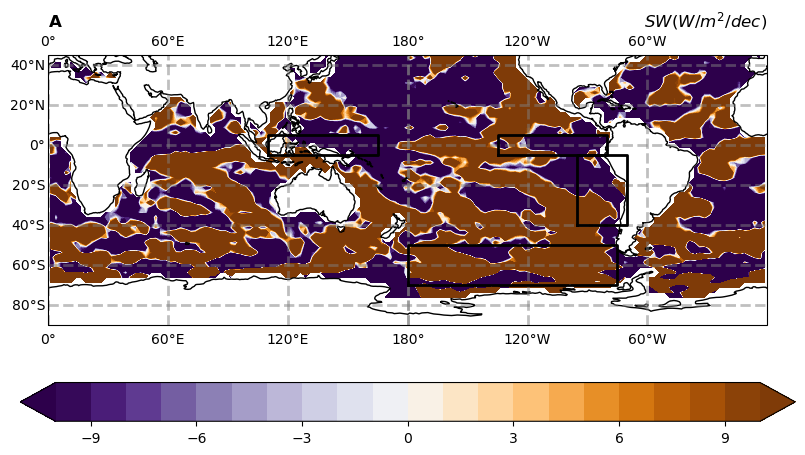

In [18]:
global_plot(
    data=SW_T.sel(model="CESM2").isel(time=0), # *12*10,
    lat=SW.lat,
    lon=SW.lon,
    pvalues=None, 
    levels=np.arange(-10, 11, 1),
    cmap="PuOr_r", 
    left_title="A", 
    right_title="$SW (W/m^2/dec)$"
)

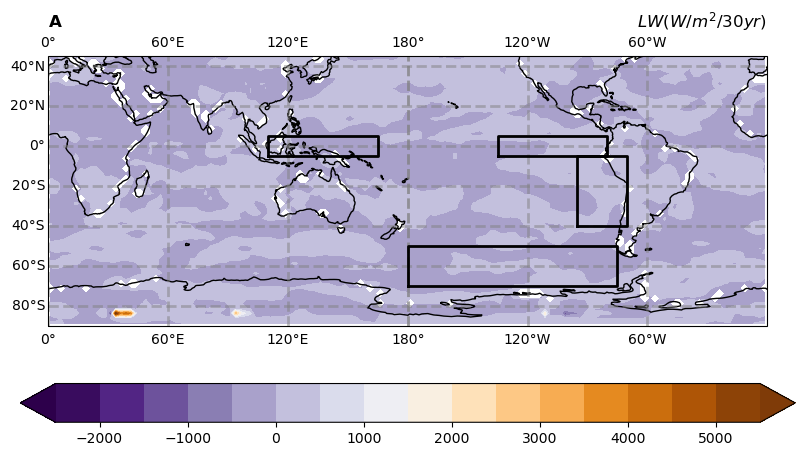

In [16]:
global_plot(
    data=LW_T.isel(model=0, time=0),
    lat=LW_T.lat,
    lon=LW_T.lon,
    pvalues=None, 
    levels=20,
    cmap="PuOr_r", 
    left_title="A", 
    right_title="$LW (W/m^2/30yr)$"
)

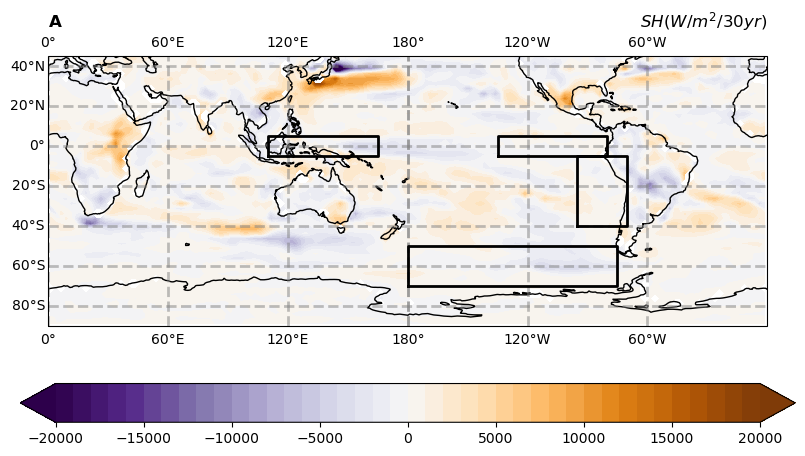

In [32]:
global_plot(
    data=SH_T.isel(model=0, time=0),
    lat=SH_T.lat,
    lon=SH_T.lon,
    pvalues=None, 
    levels=20, #np.arange(-20000, 21000, 1000),
    cmap="PuOr_r", 
    left_title="A", 
    right_title="$SH (W/m^2/30yr)$"
)

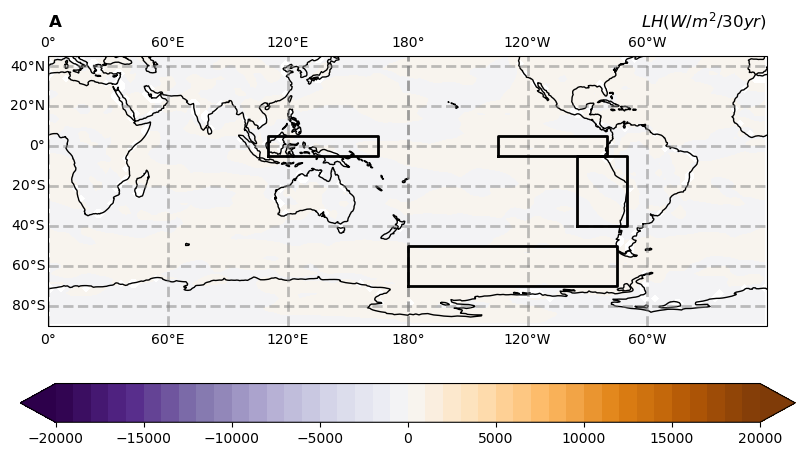

In [35]:
global_plot(
    data=LH_TW.isel(model=0, time=0),
    lat=LH_TW.lat,
    lon=LH_TW.lon,
    pvalues=None, 
    levels=np.arange(-20000, 21000, 1000),
    cmap="PuOr_r", 
    left_title="A", 
    right_title="$LH (W/m^2/30yr)$"
)
# LH_TW = W/alpha*W_Bar # Wind Driven
# LH_TRH = RH/(alpha*(np.exp(alpha*DT_Bar) - RH_Bar)) # Relative Humidity Driven
# LH_TDT

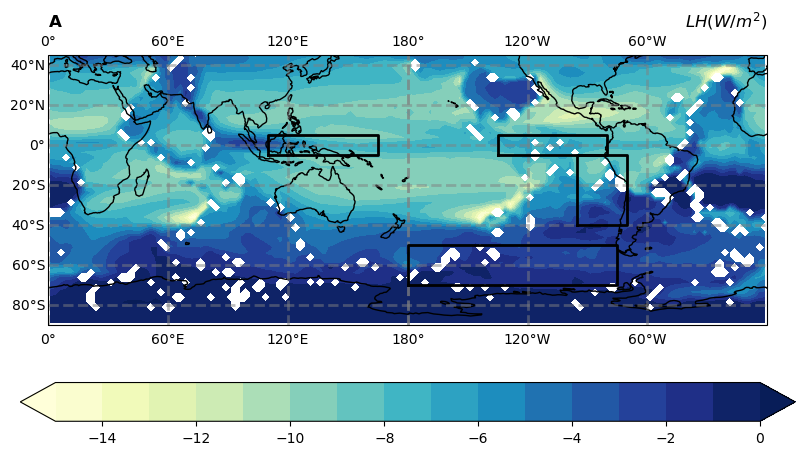

In [60]:
global_plot(
    data=-(LH_Bar*alpha).isel(model=0),
    lat=-LH_Bar.lat,
    lon=-LH_Bar.lon,
    pvalues=None, 
    levels=np.arange(-15, 1, 1), 
    cmap="YlGnBu", 
    left_title="A", 
    right_title="$LH (W/m^2)$"
)